In [332]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet101  # Using ResNet101
from tensorflow.keras.applications.resnet import preprocess_input  # ResNet preprocessing
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import json

In [333]:
# Constants
IMG_SIZE = (320, 320)  
BATCH_SIZE = 8
EPOCHS = 20
DATA_PATH = "../MURA-v1.1"
TRAIN_PATH = DATA_PATH + "/train_labeled_studies.csv"
VALID_PATH = DATA_PATH + "/valid_labeled_studies.csv"


In [334]:
# Load Data
def load_data(csv_path):
    df = pd.read_csv(csv_path, names=['Path', 'Label'], header=None)
    image_paths, labels = [], []
    base_dir = "../"  # Root dataset directory
    for _, row in df.iterrows():
        study_path = os.path.join(base_dir, row["Path"])
        label = row["Label"]
        for image_file in os.listdir(study_path):
            image_path = os.path.join(study_path, image_file)
            if image_path.endswith(".png") and not image_file.startswith("._"):
                image_paths.append(image_path)
                labels.append(label)
    return np.array(image_paths), np.array(labels)

In [335]:
train_image_paths, train_labels = load_data(TRAIN_PATH)
valid_image_paths, valid_labels = load_data(VALID_PATH)
X_train, X_test, y_train, y_test = train_test_split(train_image_paths, train_labels, test_size=0.1, stratify=train_labels, random_state=42)


In [336]:
# Convert labels into a Pandas Series
todf = pd.Series(train_labels)

# Count occurrences of each class
class_counts = todf.value_counts().to_dict()

# Get the counts (handle cases where labels might be missing)
NormalCount = class_counts.get(0, 0)  # Normal (0)
AbnormalCount = class_counts.get(1, 0)  # Abnormal (1)

# Compute class weights
w1 = NormalCount / (NormalCount + AbnormalCount)  # Weight for class 0
w2 = AbnormalCount / (NormalCount + AbnormalCount)  # Weight for class 1

class_weights = {0: w2, 1: w1}  # More weight to minority class
print("Class Weights:", class_weights)

Class Weights: {0: 0.40406976744186046, 1: 0.5959302325581395}


In [337]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [338]:
# Custom Data Generator
class MURADataGenerator(Sequence):
    def __init__(self, image_paths, labels, class_weights, batch_size=BATCH_SIZE, img_size=IMG_SIZE, augment=False, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.class_weights = class_weights
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.datagen = train_datagen if augment else None
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_paths, batch_labels)
        sample_weights = np.array([self.class_weights[label] for label in batch_labels])
        return X, y, sample_weights
    
    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_paths, self.labels))
            np.random.shuffle(temp)
            self.image_paths, self.labels = zip(*temp)
    
    def __data_generation(self, batch_paths, batch_labels):
        images = []
        for path in batch_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, self.img_size)
            img = np.stack([img] * 3, axis=-1)  # Convert to 3 channels
            img = preprocess_input(img)  # ResNet101 preprocessing
            if self.augment:
                img = self.datagen.random_transform(img)
            images.append(img)
        return np.array(images).reshape(-1, *self.img_size, 3), np.array(batch_labels)


In [339]:
# Generators
train_generator = MURADataGenerator(X_train, y_train,class_weights, augment=True)
valid_generator = MURADataGenerator(valid_image_paths, valid_labels,class_weights, augment=False, shuffle=False)
test_generator = MURADataGenerator(X_test, y_test,class_weights, augment=False, shuffle=False)


## image level performance

In [340]:
import numpy as np
def test(pred,y_test,th):# Ensure predictions are flattened
    predictions = pred.flatten()
    predictions = (predictions > th).astype(int)
    # Convert to NumPy arrays
    y_test = np.array(y_test).astype(int)
    predictions = np.array(predictions).astype(int)

    # Count correct and incorrect predictions
    true_positives = np.sum((predictions == 1) & (y_test == 1))
    true_negatives = np.sum((predictions == 0) & (y_test == 0))
    false_positives = np.sum((predictions == 1) & (y_test == 0))
    false_negatives = np.sum((predictions == 0) & (y_test == 1))

    # Print results
    print(f"True Positives: {true_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")

    # Calculate accuracy
    accuracy = (true_positives + true_negatives) / len(y_test)
    print(f"Calculated Accuracy: {accuracy * 100:.2f}%")

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"F1-Score: {f1_score:.2f}")
    from sklearn.metrics import cohen_kappa_score

    # Compute Cohen's Kappa
    kappa = cohen_kappa_score(y_test, predictions)
    print(f"Cohen's Kappa: {kappa:.2f}")


In [212]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


461/461 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step
True Positives: 1122
True Negatives: 1841
False Positives: 353
False Negatives: 365
Calculated Accuracy: 80.49%
Precision: 0.76
Recall: 0.75
F1-Score: 0.76
Cohen's Kappa: 0.59


In [213]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test,0.5)

461/461 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step
True Positives: 1198
True Negatives: 1644
False Positives: 550
False Negatives: 289
Calculated Accuracy: 77.21%
Precision: 0.69
Recall: 0.81
F1-Score: 0.74
Cohen's Kappa: 0.54


In [196]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test,0.5)

461/461 ━━━━━━━━━━━━━━━━━━━━ 48s 94ms/step
True Positives: 1021
True Negatives: 1990
False Positives: 204
False Negatives: 466
Calculated Accuracy: 81.80%
Precision: 0.83
Recall: 0.69
F1-Score: 0.75
Cohen's Kappa: 0.61


In [197]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test,0.5)

461/461 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step
True Positives: 1185
True Negatives: 1776
False Positives: 418
False Negatives: 302
Calculated Accuracy: 80.44%
Precision: 0.74
Recall: 0.80
F1-Score: 0.77
Cohen's Kappa: 0.60


In [214]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=555
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test,0.5)


[0.6297519]
[0.6769962]
[0.88547075]
[0.8647019]
[0.7642302]
1
True Positives: 1160
True Negatives: 1870
False Positives: 324
False Negatives: 327
Calculated Accuracy: 82.31%
Precision: 0.78
Recall: 0.78
F1-Score: 0.78
Cohen's Kappa: 0.63


In [215]:
# Evaluate the ensemble predictions
test(ensemble_pred, y_test,0.45)

True Positives: 1200
True Negatives: 1787
False Positives: 407
False Negatives: 287
Calculated Accuracy: 81.15%
Precision: 0.75
Recall: 0.81
F1-Score: 0.78
Cohen's Kappa: 0.61


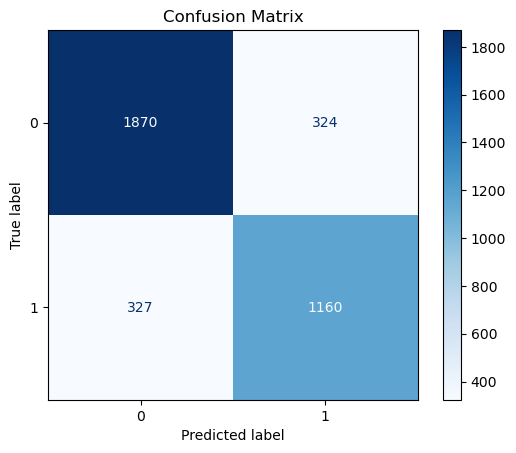

In [216]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.5).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


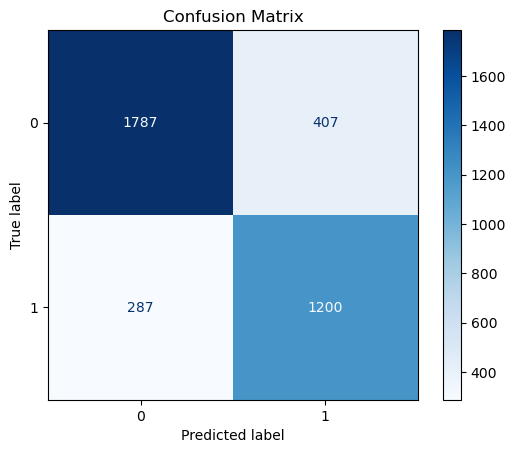

In [217]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


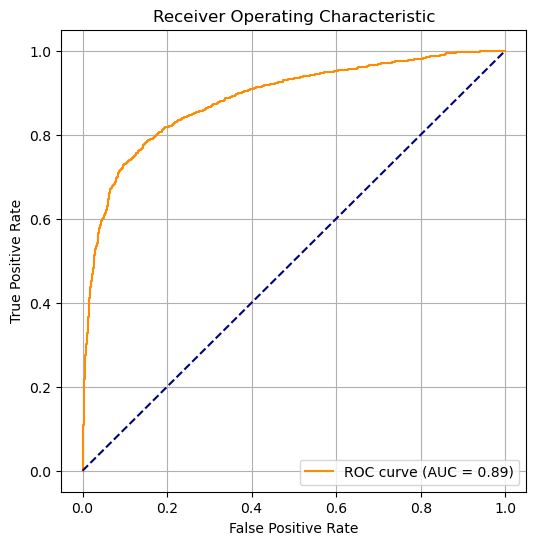

In [219]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [232]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
shoulder_mask = np.char.find(X_test.astype(str), 'XR_SHOULDER') >= 0
X_test_shoulder = X_test[shoulder_mask]
y_test_shoulder = y_test[shoulder_mask]
test_generator = MURADataGenerator(X_test_shoulder, y_test_shoulder,class_weights, augment=False, shuffle=False)


In [221]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_shoulder,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step
True Positives: 333
True Negatives: 291
False Positives: 114
False Negatives: 82
Calculated Accuracy: 76.10%
Precision: 0.74
Recall: 0.80
F1-Score: 0.77
Cohen's Kappa: 0.52


In [222]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_shoulder,0.5)

103/103 ━━━━━━━━━━━━━━━━━━━━ 25s 148ms/step
True Positives: 360
True Negatives: 260
False Positives: 145
False Negatives: 55
Calculated Accuracy: 75.61%
Precision: 0.71
Recall: 0.87
F1-Score: 0.78
Cohen's Kappa: 0.51


In [233]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_shoulder,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step
True Positives: 312
True Negatives: 326
False Positives: 79
False Negatives: 103
Calculated Accuracy: 77.80%
Precision: 0.80
Recall: 0.75
F1-Score: 0.77
Cohen's Kappa: 0.56


In [234]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_shoulder,0.5)

103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step
True Positives: 371
True Negatives: 249
False Positives: 156
False Negatives: 44
Calculated Accuracy: 75.61%
Precision: 0.70
Recall: 0.89
F1-Score: 0.79
Cohen's Kappa: 0.51


In [235]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_shoulder,0.45)


[0.9272981]
[0.94824237]
[0.9961623]
[0.997875]
[0.9673944]
1
True Positives: 369
True Negatives: 268
False Positives: 137
False Negatives: 46
Calculated Accuracy: 77.68%
Precision: 0.73
Recall: 0.89
F1-Score: 0.80
Cohen's Kappa: 0.55


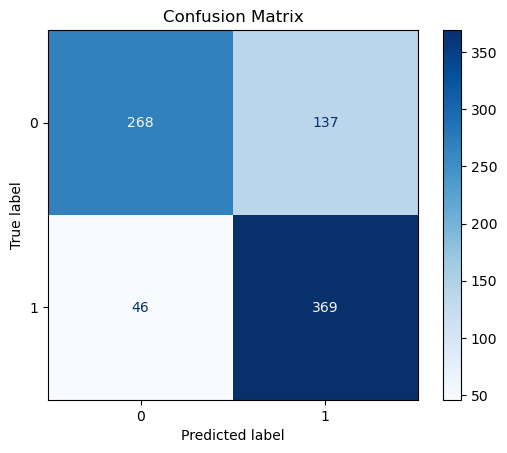

In [236]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_shoulder, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


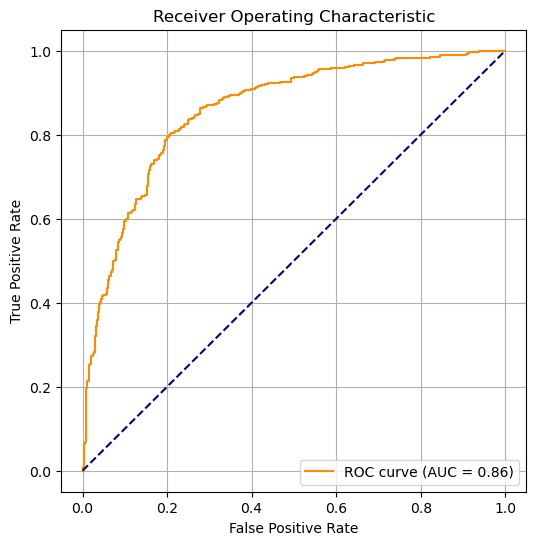

In [237]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_shoulder, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_shoulder, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [250]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
wrist_mask = np.char.find(X_test.astype(str), 'XR_WRIST') >= 0
X_test_wrist = X_test[wrist_mask]
y_test_wrist = y_test[wrist_mask]
test_generator = MURADataGenerator(X_test_wrist, y_test_wrist,class_weights, augment=False, shuffle=False)


In [251]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_wrist,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step
True Positives: 319
True Negatives: 497
False Positives: 64
False Negatives: 89
Calculated Accuracy: 84.21%
Precision: 0.83
Recall: 0.78
F1-Score: 0.81
Cohen's Kappa: 0.67


In [252]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_wrist,0.5)

122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step
True Positives: 321
True Negatives: 466
False Positives: 95
False Negatives: 87
Calculated Accuracy: 81.22%
Precision: 0.77
Recall: 0.79
F1-Score: 0.78
Cohen's Kappa: 0.62


In [239]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_wrist,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step
True Positives: 295
True Negatives: 523
False Positives: 38
False Negatives: 113
Calculated Accuracy: 84.42%
Precision: 0.89
Recall: 0.72
F1-Score: 0.80
Cohen's Kappa: 0.67


In [240]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_wrist,0.5)

122/122 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step
True Positives: 329
True Negatives: 484
False Positives: 77
False Negatives: 79
Calculated Accuracy: 83.90%
Precision: 0.81
Recall: 0.81
F1-Score: 0.81
Cohen's Kappa: 0.67


In [253]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_wrist,0.45)


[0.56334174]
[0.40254602]
[0.22623073]
[0.21083774]
[0.35073906]
1
True Positives: 332
True Negatives: 490
False Positives: 71
False Negatives: 76
Calculated Accuracy: 84.83%
Precision: 0.82
Recall: 0.81
F1-Score: 0.82
Cohen's Kappa: 0.69


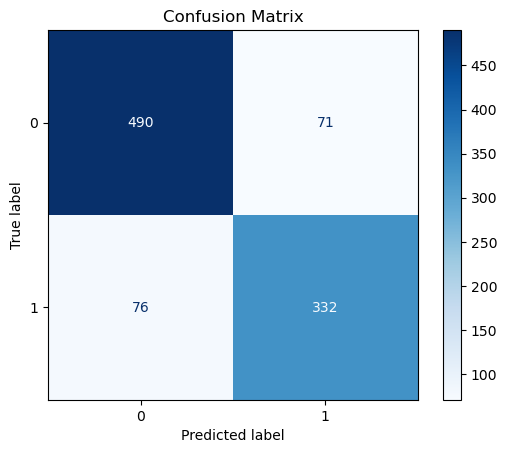

In [254]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_wrist, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


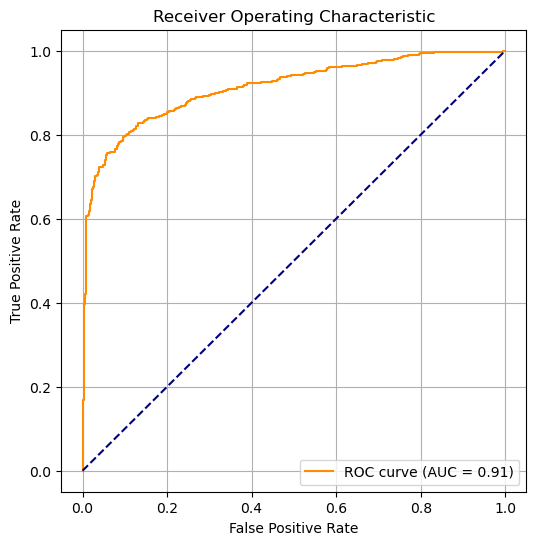

In [255]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_wrist, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_wrist, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [269]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
hand_mask = np.char.find(X_test.astype(str), 'XR_HAND') >= 0
X_test_hand = X_test[hand_mask]
y_test_hand = y_test[hand_mask]
test_generator = MURADataGenerator(X_test_hand, y_test_hand,class_weights, augment=False, shuffle=False)


In [258]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_hand,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step
True Positives: 103
True Negatives: 365
False Positives: 62
False Negatives: 61
Calculated Accuracy: 79.19%
Precision: 0.62
Recall: 0.63
F1-Score: 0.63
Cohen's Kappa: 0.48


In [259]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_hand,0.5)

74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step
True Positives: 122
True Negatives: 287
False Positives: 140
False Negatives: 42
Calculated Accuracy: 69.20%
Precision: 0.47
Recall: 0.74
F1-Score: 0.57
Cohen's Kappa: 0.35


In [270]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_hand,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step
True Positives: 85
True Negatives: 406
False Positives: 21
False Negatives: 79
Calculated Accuracy: 83.08%
Precision: 0.80
Recall: 0.52
F1-Score: 0.63
Cohen's Kappa: 0.53


In [271]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_hand,0.5)

74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step
True Positives: 100
True Negatives: 371
False Positives: 56
False Negatives: 64
Calculated Accuracy: 79.70%
Precision: 0.64
Recall: 0.61
F1-Score: 0.62
Cohen's Kappa: 0.49


In [272]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_hand,0.45)


[0.57058084]
[0.74424267]
[0.35036814]
[0.5614067]
[0.55664957]
1
True Positives: 110
True Negatives: 353
False Positives: 74
False Negatives: 54
Calculated Accuracy: 78.34%
Precision: 0.60
Recall: 0.67
F1-Score: 0.63
Cohen's Kappa: 0.48


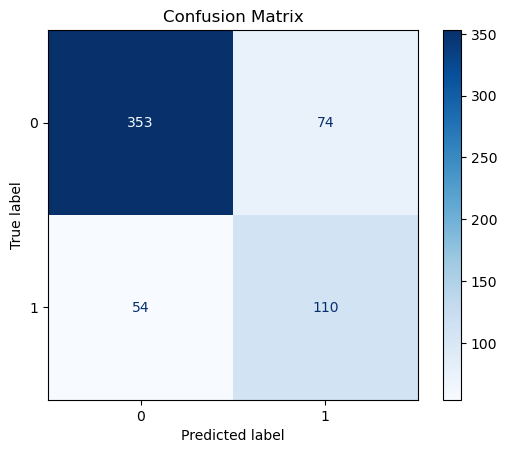

In [273]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_hand, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


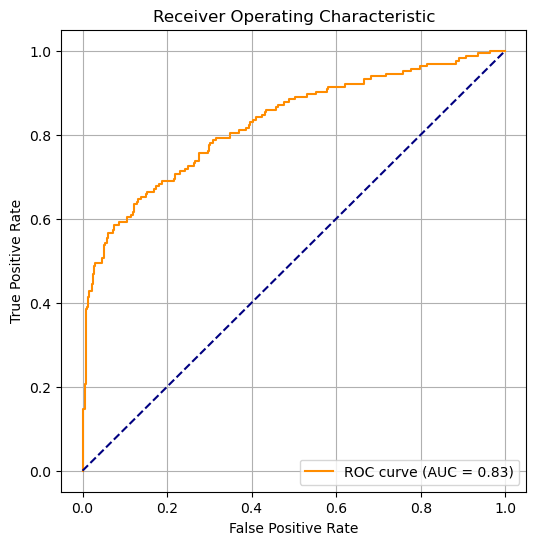

In [274]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_hand, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_hand, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [287]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
elbow_mask = np.char.find(X_test.astype(str), 'XR_ELBOW') >= 0
X_test_elbow = X_test[elbow_mask]
y_test_elbow = y_test[elbow_mask]
test_generator = MURADataGenerator(X_test_elbow, y_test_elbow,class_weights, augment=False, shuffle=False)


In [288]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_elbow,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step
True Positives: 144
True Negatives: 266
False Positives: 17
False Negatives: 69
Calculated Accuracy: 82.66%
Precision: 0.89
Recall: 0.68
F1-Score: 0.77
Cohen's Kappa: 0.64


In [289]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_elbow,0.5)

62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step
True Positives: 157
True Negatives: 247
False Positives: 36
False Negatives: 56
Calculated Accuracy: 81.45%
Precision: 0.81
Recall: 0.74
F1-Score: 0.77
Cohen's Kappa: 0.62


In [276]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_elbow,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step
True Positives: 136
True Negatives: 271
False Positives: 12
False Negatives: 77
Calculated Accuracy: 82.06%
Precision: 0.92
Recall: 0.64
F1-Score: 0.75
Cohen's Kappa: 0.62


In [277]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_elbow,0.5)

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step
True Positives: 159
True Negatives: 258
False Positives: 25
False Negatives: 54
Calculated Accuracy: 84.07%
Precision: 0.86
Recall: 0.75
F1-Score: 0.80
Cohen's Kappa: 0.67


In [290]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_elbow,0.45)


[0.26368314]
[0.3774778]
[0.29486516]
[0.13734028]
[0.2683416]
1
True Positives: 156
True Negatives: 261
False Positives: 22
False Negatives: 57
Calculated Accuracy: 84.07%
Precision: 0.88
Recall: 0.73
F1-Score: 0.80
Cohen's Kappa: 0.67


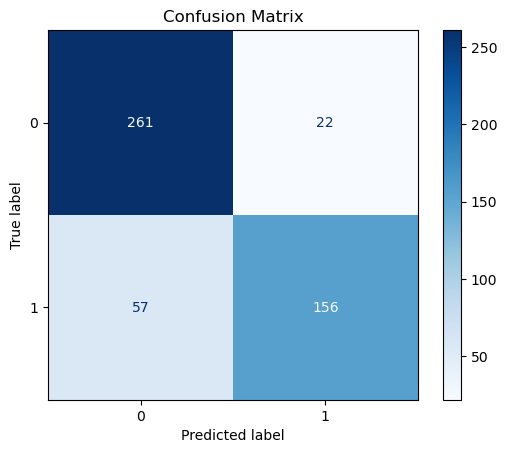

In [291]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_elbow, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


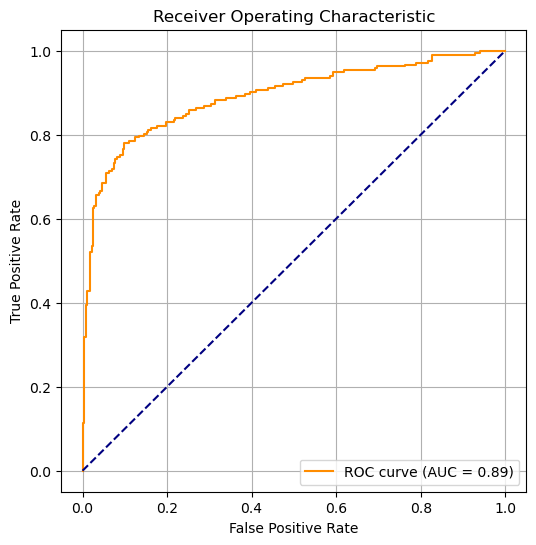

In [292]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_elbow, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_elbow, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [305]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
forearm_mask = np.char.find(X_test.astype(str), 'XR_FOREARM') >= 0
X_test_forearm = X_test[forearm_mask]
y_test_forearm = y_test[forearm_mask]
test_generator = MURADataGenerator(X_test_forearm, y_test_forearm,class_weights, augment=False, shuffle=False)


In [294]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_forearm,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step
True Positives: 46
True Negatives: 110
False Positives: 9
False Negatives: 20
Calculated Accuracy: 84.32%
Precision: 0.84
Recall: 0.70
F1-Score: 0.76
Cohen's Kappa: 0.65


In [295]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_forearm,0.5)

24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step
True Positives: 51
True Negatives: 103
False Positives: 16
False Negatives: 15
Calculated Accuracy: 83.24%
Precision: 0.76
Recall: 0.77
F1-Score: 0.77
Cohen's Kappa: 0.64


In [306]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_forearm,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step
True Positives: 49
True Negatives: 110
False Positives: 9
False Negatives: 17
Calculated Accuracy: 85.95%
Precision: 0.84
Recall: 0.74
F1-Score: 0.79
Cohen's Kappa: 0.69


In [307]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_forearm,0.5)

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step
True Positives: 52
True Negatives: 107
False Positives: 12
False Negatives: 14
Calculated Accuracy: 85.95%
Precision: 0.81
Recall: 0.79
F1-Score: 0.80
Cohen's Kappa: 0.69


In [308]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_forearm,0.45)


[0.32382917]
[0.29122734]
[0.39659262]
[0.27690718]
[0.32213908]
1
True Positives: 49
True Negatives: 111
False Positives: 8
False Negatives: 17
Calculated Accuracy: 86.49%
Precision: 0.86
Recall: 0.74
F1-Score: 0.80
Cohen's Kappa: 0.70


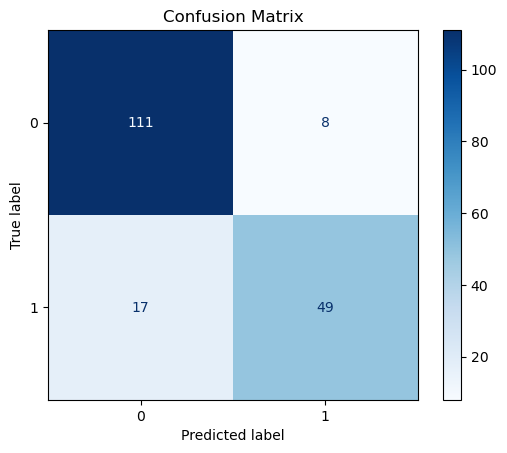

In [309]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_forearm, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


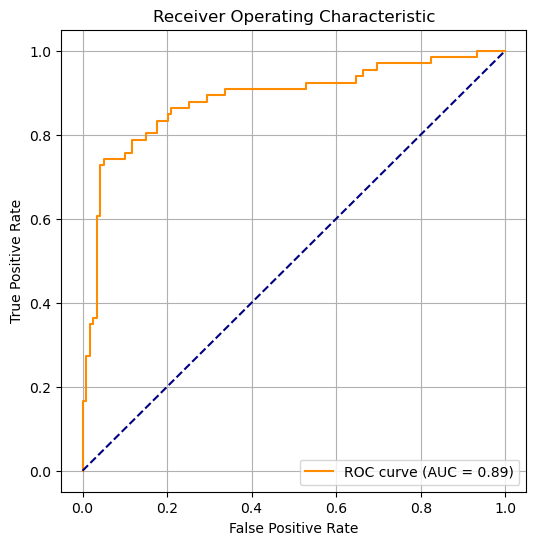

In [310]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_forearm, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_forearm, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [323]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
humerus_mask = np.char.find(X_test.astype(str), 'XR_HUMERUS') >= 0
X_test_humerus = X_test[humerus_mask]
y_test_humerus = y_test[humerus_mask]
test_generator = MURADataGenerator(X_test_humerus, y_test_humerus,class_weights, augment=False, shuffle=False)


In [324]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_humerus,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 698ms/step
True Positives: 39
True Negatives: 57
False Positives: 22
False Negatives: 5
Calculated Accuracy: 78.05%
Precision: 0.64
Recall: 0.89
F1-Score: 0.74
Cohen's Kappa: 0.56


In [325]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_humerus,0.5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 731ms/step
True Positives: 42
True Negatives: 54
False Positives: 25
False Negatives: 2
Calculated Accuracy: 78.05%
Precision: 0.63
Recall: 0.95
F1-Score: 0.76
Cohen's Kappa: 0.57


In [312]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_humerus,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step
True Positives: 39
True Negatives: 61
False Positives: 18
False Negatives: 5
Calculated Accuracy: 81.30%
Precision: 0.68
Recall: 0.89
F1-Score: 0.77
Cohen's Kappa: 0.62


In [313]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_humerus,0.5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step
True Positives: 41
True Negatives: 51
False Positives: 28
False Negatives: 3
Calculated Accuracy: 74.80%
Precision: 0.59
Recall: 0.93
F1-Score: 0.73
Cohen's Kappa: 0.51


In [326]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_humerus,0.45)


[0.00819693]
[0.11241541]
[0.21280487]
[0.26567072]
[0.14977199]
1
True Positives: 40
True Negatives: 53
False Positives: 26
False Negatives: 4
Calculated Accuracy: 75.61%
Precision: 0.61
Recall: 0.91
F1-Score: 0.73
Cohen's Kappa: 0.52


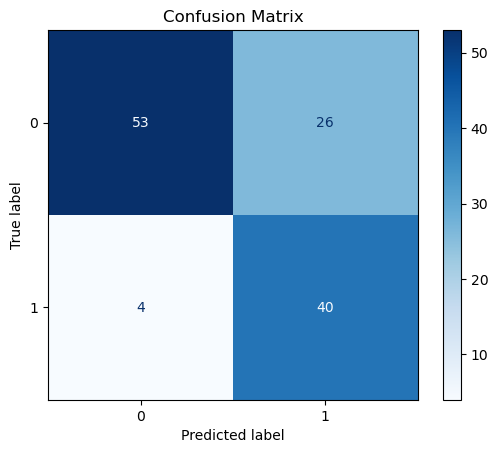

In [327]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_humerus, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


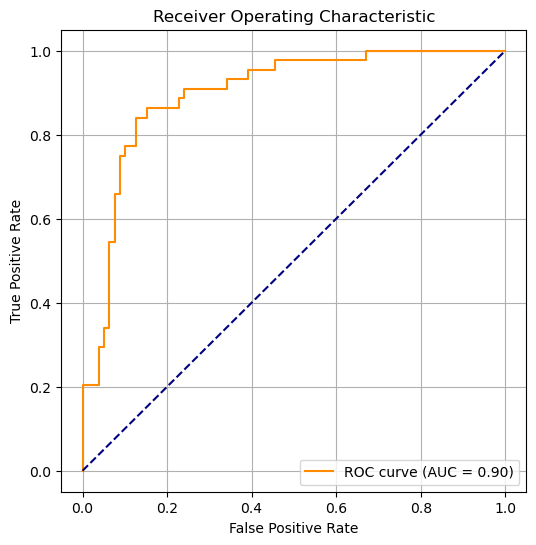

In [328]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_humerus, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_humerus, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [342]:
import numpy as np

# Convert to NumPy arrays if they aren't already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Filter only XR_SHOULDER images
finger_mask = np.char.find(X_test.astype(str), 'XR_FINGER') >= 0
X_test_finger = X_test[finger_mask]
y_test_finger = y_test[finger_mask]
test_generator = MURADataGenerator(X_test_finger, y_test_finger,class_weights, augment=False, shuffle=False)


In [330]:
model=load_model("model_epoch09_val_loss0.2801.h5")
pred1=model.predict(test_generator)
test(pred1,y_test_finger,0.5)

/home/mohammad/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 207ms/step
True Positives: 138
True Negatives: 255
False Positives: 65
False Negatives: 39
Calculated Accuracy: 79.07%
Precision: 0.68
Recall: 0.78
F1-Score: 0.73
Cohen's Kappa: 0.56


In [331]:
model=load_model("../denseModel5/model2_dense.h5")
pred2=model.predict(test_generator)
test(pred2,y_test_finger,0.5)

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step
True Positives: 145
True Negatives: 227
False Positives: 93
False Negatives: 32
Calculated Accuracy: 74.85%
Precision: 0.61
Recall: 0.82
F1-Score: 0.70
Cohen's Kappa: 0.49


In [343]:
model=load_model("resnet101_model_epoch19_val_loss0.2636.h5")
pred3=model.predict(test_generator)
test(pred3,y_test_finger,0.5)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step
True Positives: 105
True Negatives: 293
False Positives: 27
False Negatives: 72
Calculated Accuracy: 80.08%
Precision: 0.80
Recall: 0.59
F1-Score: 0.68
Cohen's Kappa: 0.54


In [344]:
model=load_model("resnet101_model2.h5")
pred4=model.predict(test_generator)
test(pred4,y_test_finger,0.5)

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step
True Positives: 133
True Negatives: 256
False Positives: 64
False Negatives: 44
Calculated Accuracy: 78.27%
Precision: 0.68
Recall: 0.75
F1-Score: 0.71
Cohen's Kappa: 0.54


In [345]:
# Compute the mean prediction
ensemble_pred = (pred1 + pred2 + pred3 + pred4) / 4
c=2
print(pred1[c])
print(pred2[c])
print(pred3[c])
print(pred4[c])
print(ensemble_pred[c])
print(y_test[c])

# Evaluate the ensemble predictions
test(ensemble_pred, y_test_finger,0.45)


[0.00530187]
[0.23411839]
[0.28215268]
[0.21090285]
[0.18311895]
1
True Positives: 144
True Negatives: 251
False Positives: 69
False Negatives: 33
Calculated Accuracy: 79.48%
Precision: 0.68
Recall: 0.81
F1-Score: 0.74
Cohen's Kappa: 0.57


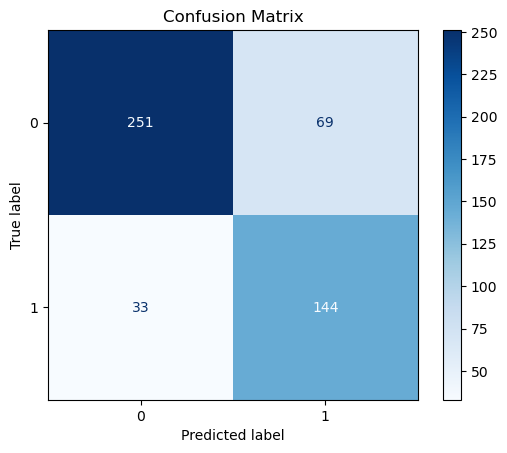

In [346]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


predictions = ensemble_pred.flatten()
predictions = (predictions > 0.45).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test_finger, predictions)

# Plot using sklearn's built-in display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # You can change the color map if you want
plt.title('Confusion Matrix')
plt.show()


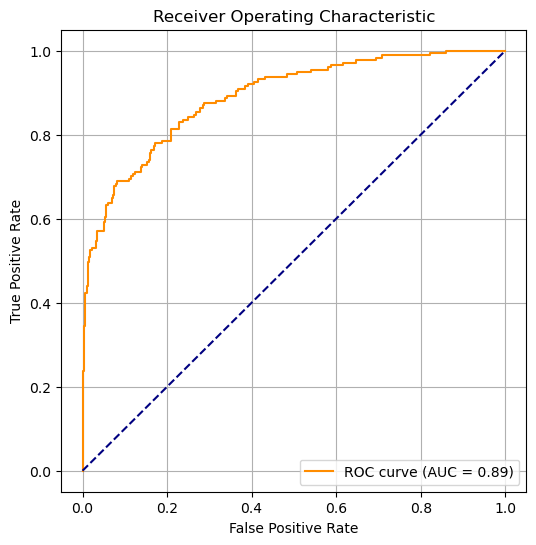

In [347]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_finger, ensemble_pred)

# Compute AUC
auc = roc_auc_score(y_test_finger, ensemble_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
